# Verkehrszeichenerkennung in Dashcam-Videos
Dieses Notebook lädt ein Eingangs-Video, erkennt Verkehrszeichen mit einem vortrainierten YOLOv5-Modell und erstellt ein Ausgangsvideo mit eingeblendeten Schildernamen.

## Schritte:
1. Imports und Setup
2. Video laden
3. Modell laden
4. Erkennung und Untertitelung
5. Ausgabevideo speichern


#import os
#os.system("pip freeze | xargs pip uninstall -y")

In [ ]:
%pip install -r requirements_notebook.txt

In [1]:
import torch
import cv2
import matplotlib.pyplot as plt
import warnings
from IPython.display import display
from PIL import Image
from ultralytics import YOLO
import numpy as np
import yaml
from ultralytics import YOLO

%matplotlib inline

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# model = torch.hub.load('ultralytics/yolov5', 'custom', path='best.pt', force_reload=True)
model = YOLO('best_v8_mb_256.pt')
model.to("mps")

print(torch.__version__)

if torch.cuda.is_available():
    device = torch.device("cuda")
elif getattr(torch.backends, "mps", None) is not None and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
model = model.to(device)

print(f"Modell läuft auf: {device}")

with open('../yolo_training/yolo_training.yaml', 'r') as f:
    data = yaml.safe_load(f)

class_names = data['names']
print(f"{len(class_names)} Klassen geladen:")
print(class_names)


# Zeitintensiv
# metrics = model.val(data="/Users/denti/develop/projects/iu_computer_vision/yolo_training_v8/data.yaml")

2.7.0
Modell läuft auf: mps
43 Klassen geladen:
['speed_limit_20', 'speed_limit_30', 'speed_limit_50', 'speed_limit_60', 'speed_limit_70', 'speed_limit_80', 'end_speed_limit_80', 'speed_limit_100', 'speed_limit_120', 'no_overtaking', 'no_overtaking_trucks', 'priority_at_next_intersection', 'priority_road', 'give_way', 'stop', 'no_entry', 'no_trucks', 'no_entry_both_directions', 'general_caution', 'curve_left', 'curve_right', 'double_curve', 'uneven_road', 'slippery_road', 'road_narrows', 'roadworks', 'traffic_signal', 'pedestrian_crossing', 'children', 'bikes', 'snow', 'wild_animals', 'no_speed_limit_overtake', 'turn_right', 'turn_left', 'go_straight', 'go_straight_or_right', 'go_straight_or_left', 'keep_right', 'keep_left', 'roundabout', 'end_no_overtaking', 'end_no_overtaking_trucks']


In [3]:
def extract_tiles(frame, tile_w=256, overlap=0.3):
    if not (0 <= overlap < 1):
        raise ValueError("overlap muss zwischen 0 (keine Überlappung) und <1 liegen.")

    tiles = []
    positions = []
    step_x = max(1, int(tile_w * (1 - overlap)))
    step_y = max(1, int(tile_w * (1 - overlap)))
    frame_h, frame_w, _ = frame.shape

    for y in range(0, frame_h - tile_w + 1, step_y):
        for x in range(0, frame_w - tile_w + 1, step_x):
            tile = frame[y:y+tile_w, x:x+tile_w]
            tiles.append(tile)
            positions.append((x, y, tile_w, tile_w))

    # Optional: letzte Spalte ergänzen, falls Rest bleibt
    if (frame_w - tile_w) % step_x != 0:
        x = frame_w - tile_w
        for y in range(0, frame_h - tile_w + 1, step_y):
            tile = frame[y:y+tile_w, x:x+tile_w]
            tiles.append(tile)
            positions.append((x, y, tile_w, tile_w))

    # Optional: letzte Zeile ergänzen, falls Rest bleibt
    if (frame_h - tile_w) % step_y != 0:
        y = frame_h - tile_w
        for x in range(0, frame_w - tile_w + 1, step_x):
            tile = frame[y:y+tile_w, x:x+tile_w]
            tiles.append(tile)
            positions.append((x, y, tile_w, tile_w))

    # Optional: rechtes unteres Eck ergänzen, falls beide Seiten einen Rest haben
    if (frame_w - tile_w) % step_x != 0 and (frame_h - tile_w) % step_y != 0:
        x = frame_w - tile_w
        y = frame_h - tile_w
        tile = frame[y:y+tile_w, x:x+tile_w]
        tiles.append(tile)
        positions.append((x, y, tile_w, tile_w))

    return tiles, positions


In [ ]:
def detect_in_tiles_deprecated(frame, frame_count, model):
    # Konfiguration intern
    TILE_W = 320
    TILE_H = 320
    INPUT_SIZE = 640
    CONF_THRESHOLD = 0.9

    frame_h, frame_w, _ = frame.shape
    result_frame = frame.copy()

    for y in range(0, frame_h, TILE_H):
        for x in range(0, frame_w, TILE_W):
            # Debug-Raster
            # cv2.rectangle(result_frame, (x, y), (x + TILE_W, y + TILE_H), (200, 200, 200), 1)
            
            tile = frame[y:y + TILE_H, x:x + TILE_W]
            if tile.shape[0] != TILE_H or tile.shape[1] != TILE_W:
                continue

            tile_resized = cv2.resize(tile, (INPUT_SIZE, INPUT_SIZE))
            results = model(tile_resized, verbose=False)
            boxes = results[0].boxes

            if boxes is None:
                continue

            for box in boxes:
                conf = float(box.conf)
                # Conf-Fallunterscheidung
                # if conf < CONF_THRESHOLD:
                    # continue

                x1, y1, x2, y2 = box.xyxy[0].tolist()
                cls_index = int(box.cls)

                # Rückskalierung
                scale_x = TILE_W / INPUT_SIZE
                scale_y = TILE_H / INPUT_SIZE
                x1 = int(x + x1 * scale_x)
                y1 = int(y + y1 * scale_y)
                x2 = int(x + x2 * scale_x)
                y2 = int(y + y2 * scale_y)

                # Debug-Raster
                # cv2.rectangle(result_frame, (x1, y1), (x1 + TILE_W, y1 + TILE_H), (200, 200, 200), 1)

                if conf < CONF_THRESHOLD:
                    continue

                label = model.names[cls_index]
                cv2.rectangle(result_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(result_frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
                print(f"{label} erkannt mit conf={conf:.2f} in Frame {frame_count}")

                
    return result_frame


In [ ]:
def detect_in_tiles_deprecated(frame, frame_count, model):
    TILE_W = 100
    TILE_H = 100
    CONF_THRESHOLD = 0.9

    # Extrahiere explizit die gewünschten Tiles
    tiles = []
    positions = []
    H, W, _ = frame.shape

    # Obere und untere Reihen, jeweils links und rechts
    for row in [0, H - TILE_H]:
        for col in [0, W - TILE_W]:
            tile = frame[row:row+TILE_H, col:col+TILE_W]
            tiles.append(tile)
            positions.append((col, row, TILE_W, TILE_H))

    results = model(tiles, verbose=False)

    result_frame = frame.copy()
    for idx, res in enumerate(results):
        boxes = res.boxes
        if boxes is None:
            continue

        x_off, y_off, tw, th = positions[idx]
        for box in boxes:
            conf = float(box.conf)
            if conf < CONF_THRESHOLD:
                continue
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            cls_index = int(box.cls)
            x1 = int(x_off + x1)
            y1 = int(y_off + y1)
            x2 = int(x_off + x2)
            y2 = int(y_off + y2)
            label = model.names[cls_index]
            cv2.rectangle(result_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(result_frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            print(f"{label} erkannt mit conf={conf:.2f} in Frame {frame_count}")

    return result_frame


In [4]:
def detect_in_tiles(frame, frame_count, model):
    TILE_W = 128
    OVERLAP = 0.3
    CONF_THRESHOLD = 0.9

    tiles, positions = extract_tiles(frame, TILE_W, OVERLAP)
    # Kein Resizing mehr nötig
    results = model(tiles, verbose=False)

    result_frame = frame.copy()
    for idx, res in enumerate(results):
        boxes = res.boxes
        if boxes is None:
            continue

        x_off, y_off, tw, th = positions[idx]
        # Kein Skalierungsfaktor mehr nötig
        for box in boxes:
            conf = float(box.conf)
            if conf < CONF_THRESHOLD:
                continue
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            cls_index = int(box.cls)
            x1 = int(x_off + x1)
            y1 = int(y_off + y1)
            x2 = int(x_off + x2)
            y2 = int(y_off + y2)
            label = model.names[cls_index]
            cv2.rectangle(result_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(result_frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            print(f"{label} erkannt mit conf={conf:.2f} in Frame {frame_count}")

    return result_frame


In [5]:
# Bild laden und in RGB umwandeln
image_path = "snapshot.png"
img_bgr = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

processed = detect_in_tiles(img_bgr, 0, model)

# Anzeige
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(processed)
ax.axis('off')
plt.show()

In [9]:
video_path = 'input_videos/gute_sicht_720p.mp4'
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Fehler: Video konnte nicht geöffnet werden.")
else:
    print("Video erfolgreich geöffnet.")

ret, frame = cap.read()
if not ret:
    print("Kein Frame gelesen.")
else:
    print("Frame gelesen:", frame.shape)

fps = cap.get(cv2.CAP_PROP_FPS)
print("Video-FPS:", fps)

Video erfolgreich geöffnet.
Frame gelesen: (720, 1280, 3)
Video-FPS: 29.97002997002997


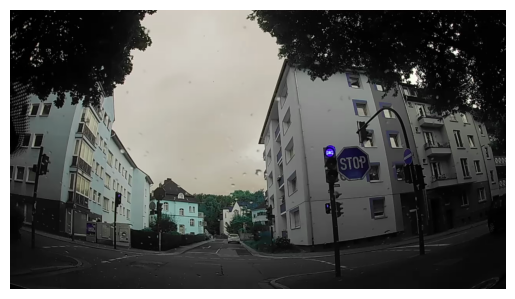

In [10]:
img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame = detect_in_tiles(frame, 0, model)
fig, ax = plt.subplots()
ax.imshow(frame)
ax.axis('off')
display(fig)
plt.close(fig)
# Image.fromarray(img_rgb).save("snapshot.png")

In [ ]:
# VIDEOANALYSE
MAX_FRAMES = 999999
FRAME_START = 0

# Frame-Parameter
OUTPUT_W = 1920
OUTPUT_H = 1080
#OUTPUT_W = 1280
#OUTPUT_H = 720

# Initialisierung
frame_count = FRAME_START

cap.release()
cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count)

output_path = 'output_videos/ergebnis_720p.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = cap.get(cv2.CAP_PROP_FPS)
output_frame_size = (OUTPUT_W, OUTPUT_H)
writer = cv2.VideoWriter(output_path, fourcc, fps, output_frame_size)
print("VideoWriter initialisiert.")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    processed_frame = detect_in_tiles(frame, frame_count, model)

    writer.write(cv2.cvtColor(processed_frame, cv2.COLOR_RGB2BGR))

    frame_count += 1
    if frame_count % 100 == 0:
        print(f"{frame_count} Frames verarbeitet.")

    if frame_count >= MAX_FRAMES:
        print(f"Es wurden {MAX_FRAMES} Frames verarbeitet und die Verarbeitung wird beendet.")
        break

cap.release()
writer.release()
print("Fertig.")

In [ ]:
# LEGACY - DEPRECATED - OUTPUT-VIDEO 640 x 640

# Schwellenwerte
CONF_THRESHOLD = 0.3
MAX_FRAMES = 999999
FRAME_START = 0

# Frame-Parameter
FRAME_W = 1920
FRAME_H = 1080

# Rescaling der Frames, so dass es zum Modell passt
TARGET_W = 640
TARGET_H = 360
PADDING_V = 140
PADDING_H = 0

# Modellparameter
MODEL_INPUT_SIZE = 640

# Initialisierung
frame_count = FRAME_START

cap.release()
cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count)

output_path = 'output_videos/ergebnis_640.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_frame_size = (MODEL_INPUT_SIZE, MODEL_INPUT_SIZE)
writer = cv2.VideoWriter(output_path, fourcc, fps, output_frame_size)
print("VideoWriter initialisiert.")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(frame_rgb, (TARGET_W, TARGET_H))
    img_resized = cv2.copyMakeBorder(resized, PADDING_V, PADDING_V, PADDING_H, PADDING_H, cv2.BORDER_CONSTANT, value=(114, 114, 114))

    input_tensor = torch.from_numpy(img_resized).permute(2, 0, 1).unsqueeze(0).float() / 255.0

    with torch.no_grad():
        preds = model(input_tensor)[0].cpu().tolist()

    for pred in preds:
        # print(f"pred: {pred}")
        cx, cy, w, h = pred[0], pred[1], pred[2], pred[3]
        objectness = pred[4]
        class_scores = pred[5:]

        max_score = max(class_scores)
        conf = objectness * max_score
        if conf < CONF_THRESHOLD:
            continue

        cls_index = class_scores.index(max_score)
        print(f"conf={conf:.4f} für Klasse {cls_index}")

        x1 = int(cx - w / 2)
        y1 = int(cy - h / 2)
        x2 = int(cx + w / 2)
        y2 = int(cy + h / 2)

        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(MODEL_INPUT_SIZE, x2)
        y2 = min(MODEL_INPUT_SIZE, y2)

        print(f"Rechteck: {x1},{y1} -> {x2},{y2}")

        label = class_names[cls_index]
        cv2.rectangle(img_resized, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_resized, label, (10, MODEL_INPUT_SIZE - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        print(f"Gezeichnet: {label}")

    writer.write(cv2.cvtColor(img_resized, cv2.COLOR_RGB2BGR))

    frame_count += 1
    if frame_count % 100 == 0:
        print(f"{frame_count} Frames verarbeitet.")

    if frame_count >= MAX_FRAMES:
        print(f"Es wurden {MAX_FRAMES} Frames verarbeitet und die Verarbeitung wird beendet.")
        break     

cap.release()
writer.release()
print("Fertig.")


In [ ]:
# LEGACY - DEPRECATED - SMALL INPUT FORMAT
# OUTPUT-VIDEO 1280 x 720

# Schwellenwerte
CONF_THRESHOLD = 0.6
MAX_BOX_AREA_RATIO = 0.08
MAX_FRAMES = 100
FRAME_START = 0

# Frame-Parameter
FRAME_H = 720
FRAME_W = 1280

# Rescaling der Frames, so dass es zum Modell passt
TARGET_W = 640
TARGET_H = 360
SCALE = 2
PADDING_V = 140
PADDING_H = 0

# Modellparameter
MODEL_INPUT_SIZE = 640

# Abgeleitete Werte
MAX_BOX_AREA = MAX_BOX_AREA_RATIO * FRAME_W * FRAME_H

# Initialisierung
frame_count = FRAME_START

cap.release()
cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count)

output_path = 'output_videos/ergebnis.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_frame_size = (FRAME_W, FRAME_H)

writer = cv2.VideoWriter(output_path, fourcc, fps, output_frame_size)
print("VideoWriter initialisiert.")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(frame_rgb, (TARGET_W, TARGET_H))
    img_resized = cv2.copyMakeBorder(resized, PADDING_V, PADDING_V, PADDING_H, PADDING_H, cv2.BORDER_CONSTANT, value=(114, 114, 114))

    input_tensor = torch.from_numpy(img_resized).permute(2, 0, 1).unsqueeze(0).float() / 255.0

    with torch.no_grad():
        preds = model(input_tensor)[0].cpu().tolist()

    for pred in preds:
        # print(f"pred: {pred}")
        cx, cy, w, h = pred[0], pred[1], pred[2], pred[3]
        objectness = pred[4]
        class_scores = pred[5:]

        max_score = max(class_scores)
        conf = objectness * max_score
        if conf < CONF_THRESHOLD:
            continue

        cls_index = class_scores.index(max_score)
        print(f"conf={conf:.4f} für Klasse {cls_index}")

        x1 = cx - w / 2
        y1 = cy - h / 2
        x2 = cx + w / 2
        y2 = cy + h / 2

        draw_x1 = int(x1 * SCALE)
        draw_y1 = int((y1 - PADDING_V) * SCALE)
        draw_x2 = int(x2 * SCALE)
        draw_y2 = int((y2 - PADDING_V) * SCALE)

        draw_x1 = max(0, draw_x1)
        draw_y1 = max(0, draw_y1)
        draw_x2 = min(FRAME_W, draw_x2)
        draw_y2 = min(FRAME_H, draw_y2)
        print(f"Rechteck: {draw_x1},{draw_y1} -> {draw_x2},{draw_y2}")

        box_area = (draw_x2 - draw_x1) * (draw_y2 - draw_y1)
        #if box_area > MAX_BOX_AREA:
        #    print(f"Übersprungen wegen Größe: {box_area}px")
        #    continue

        label = class_names[cls_index]
        cv2.rectangle(frame, (draw_x1, draw_y1), (draw_x2, draw_y2), (0, 255, 0), 2)
        cv2.putText(frame, label, (10, frame.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        print(f"Gezeichnet: {label}")

    writer.write(frame)

    frame_count += 1
    if frame_count % 100 == 0:
        print(f"{frame_count} Frames verarbeitet.")

    if frame_count >= MAX_FRAMES:
        print(f"Es wurden {MAX_FRAMES} Frames verarbeitet und die Verarbeitung wird beendet.")
        break     

cap.release()
writer.release()
print("Fertig.")


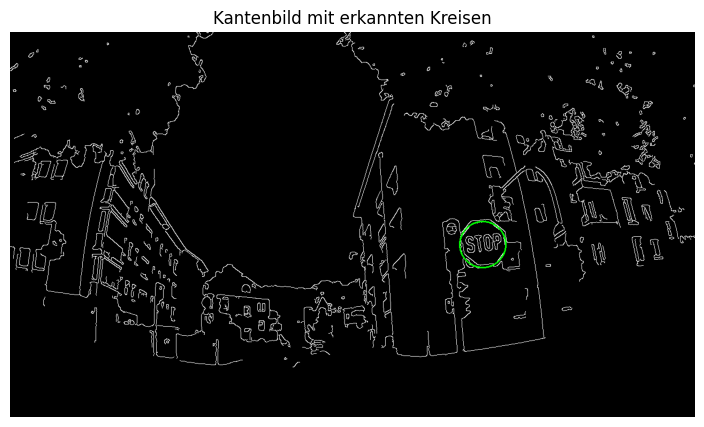

In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

video_path = 'input_videos/gute_sicht_720p.mp4'
cap = cv2.VideoCapture(video_path)

ret, frame = cap.read()
if ret:
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray, 5)

    # Canny-Kantenbild erzeugen
    edges = cv2.Canny(gray, threshold1=100, threshold2=300)

    # Hough-Kreise im Kantenbild suchen
    circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=1.2, minDist=80,
                               param1=50, param2=60, minRadius=20, maxRadius=50)

    # Kopie für Darstellung der Kreise im Kantenbild
    edges_rgb = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

    if circles is not None:
        circles = np.uint16(np.around(circles))
        for (x, y, r) in circles[0, :]:
            cv2.circle(edges_rgb, (x, y), r, (0, 255, 0), 2)

    # Anzeige im Notebook
    plt.figure(figsize=(10, 5))
    plt.title("Kantenbild mit erkannten Kreisen")
    plt.imshow(edges_rgb)
    plt.axis('off')
    plt.show()

cap.release()


In [ ]:
import cv2
import numpy as np

video_path = 'input_videos/gute_sicht_720p.mp4'
output_path = 'output_videos/kanten_kreise.mp4'

cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (w, h))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray, 5)

    edges = cv2.Canny(frame, threshold1=200, threshold2=400)
    edges_rgb = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

    circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=1.2, minDist=80,
                               param1=50, param2=60, minRadius=20, maxRadius=50)

    if circles is not None:
        circles = np.uint16(np.around(circles))
        for (x, y, r) in circles[0, :]:
            cv2.circle(edges_rgb, (x, y), r, (0, 255, 0), 2)

    out.write(edges_rgb)

cap.release()
out.release()
print("Fertig. Ergebnis gespeichert als", output_path)


Fertig. Ergebnis gespeichert als output_videos/kanten_kreise.mp4


Tile 0: no_entry_both_directions erkannt mit conf=0.94
Tile 1: stop erkannt mit conf=0.95


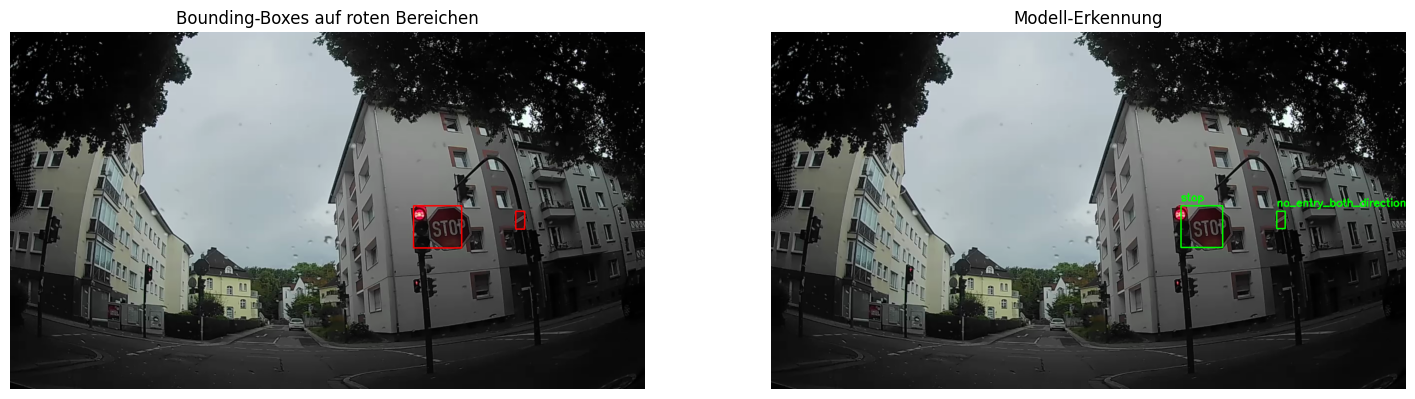

In [52]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

video_path = 'input_videos/gute_sicht_720p.mp4'
model_path = '/Users/denti/develop/projects/iu_computer_vision/notebook/best_v8_mb_256.pt'
model = YOLO(model_path)

cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
if ret:
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    lower_red1 = np.array([0, 120, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 120, 50])
    upper_red2 = np.array([180, 255, 255])

    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    mask = cv2.bitwise_or(mask1, mask2)

    kernel = np.ones((30, 30), np.uint8)
    mask_closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(mask_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bboxes = []
    tiles = []
    orig_coords = []

    # Bild für Bounding-Boxes auf roten Bereichen
    red_boxes_img = frame.copy()

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 10 and h > 10:
            bboxes.append((x, y, x + w, y + h))
            roi = frame[y:y+h, x:x+w]
            roi_resized = cv2.resize(roi, (256, 256))
            tiles.append(roi_resized)
            orig_coords.append((x, y, x + w, y + h))
            cv2.rectangle(red_boxes_img, (x, y), (x + w, y + h), (0, 0, 255), 2)

    # Bild für Modell-Ergebnisse
    model_img = frame.copy()

    if tiles:
        results = model(tiles, verbose=False)

        for idx, res in enumerate(results):
            boxes = res.boxes
            x0, y0, x1, y1 = orig_coords[idx]
            scale_x = (x1 - x0) / 256
            scale_y = (y1 - y0) / 256

            if boxes is not None:
                for box in boxes:
                    conf = float(box.conf)
                    if conf < 0.5:
                        continue
                    bx1, by1, bx2, by2 = box.xyxy[0].tolist()
                    cls_index = int(box.cls)
                    bx1 = int(x0 + bx1 * scale_x)
                    by1 = int(y0 + by1 * scale_y)
                    bx2 = int(x0 + bx2 * scale_x)
                    by2 = int(y0 + by2 * scale_y)
                    label = res.names[cls_index]
                    cv2.rectangle(model_img, (bx1, by1), (bx2, by2), (0, 255, 0), 2)
                    cv2.putText(model_img, label, (bx1, by1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
                    print(f"Tile {idx}: {label} erkannt mit conf={conf:.2f}")

    # Ausgabe beider Bilder
    plt.figure(figsize=(18, 12))
    plt.subplot(1, 2, 1)
    plt.title('Bounding-Boxes auf roten Bereichen')
    plt.imshow(cv2.cvtColor(red_boxes_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Modell-Erkennung')
    plt.imshow(cv2.cvtColor(model_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()

cap.release()


In [3]:
import cv2
import numpy as np

def find_red_bboxes(hsv, kernel_size=15, min_box=10, max_box=100):
    """
    Sucht rote Bereiche im HSV-Bild und gibt Bounding-Boxes zurück.
    Args:
        hsv: HSV-Bild (np.ndarray)
        kernel_size: Größe für morphologisches Closing
        min_box, max_box: Min-/Max-Seitenlänge der Bounding-Box
    Returns:
        Liste mit Bounding-Boxes [(x_min, y_min, x_max, y_max), ...]
    """
    lower_red1 = np.array([0, 150, 80])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 150, 80])
    upper_red2 = np.array([180, 255, 255])

    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    mask = cv2.bitwise_or(mask1, mask2)

    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    mask_closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(mask_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bboxes = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > min_box and h > min_box and w < max_box and h < max_box:
            bboxes.append((x, y, x + w, y + h))
    return bboxes


In [4]:
import cv2
import numpy as np

def find_blue_bboxes(hsv, kernel_size=15, min_box=10, max_box=100):
    """
    Sucht blaue Bereiche im HSV-Bild und gibt Bounding-Boxes zurück.
    Args:
        hsv: HSV-Bild (np.ndarray)
        kernel_size: Größe für morphologisches Closing
        min_box, max_box: Min-/Max-Seitenlänge der Bounding-Box
    Returns:
        Liste mit Bounding-Boxes [(x_min, y_min, x_max, y_max), ...]
    """
    
    lower_blue = np.array([105, 180, 120])
    upper_blue = np.array([125, 255, 255])


    mask = cv2.inRange(hsv, lower_blue, upper_blue)
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    mask_closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(mask_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bboxes = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > min_box and h > min_box and w < max_box and h < max_box:
            bboxes.append((x, y, x + w, y + h))
    return bboxes


In [5]:
def extract_tiles(frame, bboxes, tile_size=(256, 256)):
    """
    Schneidet aus dem Bild die Bereiche gemäß Bounding-Boxes aus
    und resized sie auf die gewünschte Größe.
    Args:
        frame: BGR-Frame (np.ndarray)
        bboxes: Liste Bounding-Boxes [(x_min, y_min, x_max, y_max), ...]
        tile_size: Zielgröße (Breite, Höhe) als Tuple
    Returns:
        Liste der Tiles (np.ndarray), Liste der Bounding-Boxen (wie übergeben)
    """
    tiles = []
    for (x_min, y_min, x_max, y_max) in bboxes:
        roi = frame[y_min:y_max, x_min:x_max]
        roi_resized = cv2.resize(roi, tile_size)
        tiles.append(roi_resized)
    return tiles


In [7]:
import cv2
import numpy as np
from ultralytics import YOLO

# --- Hilfsfunktionen aus vorherigen Zellen einfügen ---
# def find_red_bboxes(hsv, ...) ...
# def find_blue_bboxes(hsv, ...) ...
# def extract_tiles(...) ...

video_path = 'input_videos/gute_sicht_720p.mp4'
output_path = 'output_videos/ergebnis_rot_model.mp4'
model_path = '/Users/denti/develop/projects/iu_computer_vision/notebook/best_v8_mb_256.pt'
model = YOLO(model_path)

cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (w, h))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Helligkeit/Sättigung einmalig für den Frame anpassen
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    #hsv[..., 1] = np.clip(hsv[..., 1] + 30, 0, 255)
    #hsv[..., 2] = np.clip(hsv[..., 2] + 30, 0, 255)

    # Bounding-Boxes der roten Bereiche suchen
    red_bboxes = find_red_bboxes(hsv, kernel_size=30, min_box=15, max_box=90)
    # blue_bboxes = find_blue_bboxes(hsv, kernel_size=20, min_box=15, max_box=60)
    bboxes = red_bboxes # + blue_bboxes
    
    tiles = extract_tiles(frame, bboxes, tile_size=(256, 256))

    result_frame = frame.copy()
    orig_coords = bboxes
    if tiles:
        results = model(tiles, verbose=False)
        for idx, res in enumerate(results):
            boxes = res.boxes
            x0, y0, x1, y1 = orig_coords[idx]
            scale_x = (x1 - x0) / 256
            scale_y = (y1 - y0) / 256
            if boxes is not None:
                for box in boxes:
                    conf = float(box.conf)
                    if conf < 0.9:
                        continue
                    bx1, by1, bx2, by2 = box.xyxy[0].tolist()
                    cls_index = int(box.cls)
                    bx1 = int(x0 + bx1 * scale_x)
                    by1 = int(y0 + by1 * scale_y)
                    bx2 = int(x0 + bx2 * scale_x)
                    by2 = int(y0 + by2 * scale_y)
                    label = res.names[cls_index]
                    cv2.rectangle(result_frame, (bx1, by1), (bx2, by2), (0, 255, 0), 2)
                    cv2.putText(result_frame, label, (bx1, by1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    out.write(result_frame)

cap.release()
out.release()
print("Fertig. Ergebnis gespeichert als", output_path)


Fertig. Ergebnis gespeichert als output_videos/ergebnis_rot_model.mp4
